# Projeto Final - Ciência dos dados
### Alunos:
- Beatriz Lourenço 
- Fernando Kenji 
- Sophia Kerber
- Pedro H. Menezes

### Pergunta Motivadora:
É possível prever a avaliação de um livro (no ranking do Goodreads) com as seguintes variáveis?
- Inicial do autor
- Número de páginas
- Gênero
- Formato do livro (Capa dura, capa em papel, versão Kindle...)


### Por que regressão linear?


Como o objetivo do projeto era prever a avaliação do livro, decidiu-se utilizar a regressão linear para tanto, uma vez que a variável de saída é quantitativa. A ideia da regressão linear é aproximar os dados de uma reta, tentando diminuir o erro quadrático ao máximo. Utilizamos o One Hot Enconder, aliado ao SciKitLearn para dividir o dataset, classificar as variáveis qualitativas em números binários, e finalmente fazer a predição e o teste do dataset.

As técnicas que se prestam a este tipo de análise: regressão linear, *regression tree*, *random forest regression* - EXPLICAR OS OUTROS 2

### Como melhorar a análise?

Pode-se melhorar a análise feita por meio da K-Folds Cross Validation.

In [1]:
#Importando bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [2]:
# Base de dados original
csv = pd.read_csv('book_data.csv')
csv.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [31]:
# Limpando variáveis que não usaremos na análise para retirar os dados com informações faltantes
csv.drop(['book_isbn','book_desc','book_edition','book_title','book_rating_count','book_review_count','image_url'],axis=1,inplace=True)
# Retirando os livros com informações faltando
csv=csv.dropna()
csv.head()

KeyError: "['book_isbn' 'book_desc' 'book_edition' 'book_title' 'book_rating_count'\n 'book_review_count' 'image_url'] not found in axis"

In [4]:
# Ajeitando as variáveis qualitativas
ar = csv['genres'].value_counts()
ar1 = []
iniciais = []
paginas = []

# Escolhendo como gênero literário apenas o primeiro listado.
for i in ar.index:
    if i == "":
        ar1.append("")
    else:
        a = i.split('|')
        ar1.append(a[0])
        
# Selecionando apenas a inicial dos nomes dos autores
for i in csv['book_authors']:
    iniciais.append(i[0])

# Apenas o número de páginas aparecerá, sem a palavra "pages"
for i in csv['book_pages']:
    numero = i.split(' ')
    paginas.append(int(numero[0]))
print(paginas[0:10])
print(iniciais[0:10])
print(ar1[0:10])

[374, 870, 324, 279, 498, 552, 767, 122, 1037, 1728]
['S', 'J', 'H', 'J', 'S', 'M', 'C', 'G', 'M', 'J']
['Fiction', 'Novels', 'Science Fiction', 'Poetry', 'Fantasy', 'Nonfiction', 'Fantasy', 'Historical', 'Childrens', 'Romance']


In [6]:
# Criando colunas no DataFrame para as iniciais dos autores, os números de páginas e o principal gênero do livro
ar1=pd.DataFrame({'genero':ar1})
iniciais_ = pd.DataFrame({'iniciais':iniciais})
paginas_ = pd.DataFrame({'paginas':paginas})

In [7]:
# Juntando os dados do DataFrame com os ajeitados 
csv = csv.join(ar1,how='inner')
csv = csv.join(iniciais_,how='inner')
csv = csv.join(paginas_,how='inner')
csv.head()

,book_authors,book_format,book_pages,book_rating,genres,genero,iniciais,paginas
0,Suzanne Collins,Hardcover,374 pages,4.33,Young Adult|Fiction|Science Fiction|Dystopia|F...,Fiction,S,374
1,J.K. Rowling|Mary GrandPré,Paperback,870 pages,4.48,Fantasy|Young Adult|Fiction,Novels,J,870
2,Harper Lee,Paperback,324 pages,4.27,Classics|Fiction|Historical|Historical Fiction...,Science Fiction,H,324
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,Paperback,279 pages,4.25,Classics|Fiction|Romance,Poetry,J,279
4,Stephenie Meyer,Paperback,498 pages,3.58,Young Adult|Fantasy|Romance|Paranormal|Vampire...,Fantasy,S,498


In [8]:
# Retirando as colunas irrelevantes para a análise geral de avaliações
csv.drop(['book_authors','genres','book_pages'],axis=1,inplace=True)

In [9]:
csv.head()

,book_format,book_rating,genero,iniciais,paginas
0,Hardcover,4.33,Fiction,S,374
1,Paperback,4.48,Novels,J,870
2,Paperback,4.27,Science Fiction,H,324
3,Paperback,4.25,Poetry,J,279
4,Paperback,3.58,Fantasy,S,498


In [13]:
# Separando as variáveis em quantitativas, qualitativas e a desejada
y = csv['book_rating'].values
num = csv[['paginas']]
qual = csv[['book_format','genero','iniciais']]

In [14]:
qual.head()

,book_format,genero,iniciais
0,Hardcover,Fiction,S
1,Paperback,Novels,J
2,Paperback,Science Fiction,H
3,Paperback,Poetry,J
4,Paperback,Fantasy,S


In [15]:
#Transformando as qualitativas em quantitativas
encoder = OneHotEncoder()
capa_encoded = encoder.fit_transform(qual)

In [16]:
# Pegando somente os valores que já são quantitativos
x_num = num.values

In [17]:
#Transformar em array facilita a exploração dos dados
x_encoded = capa_encoded.toarray()

In [18]:
#Juntando a lista binária e as páginas
X = np.concatenate((x_num,x_encoded), axis=1)

In [19]:
# Informações transformadas em quantitativas de todas as variáveis do livro 1
X[0]

array([374.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [20]:
#Rating do livro 1
y[0]

4.33

In [32]:
# Treinando o modelo para a regressão linear
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing,utils, metrics
from sklearn.linear_model import LinearRegression

# Separando a parte de teste e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Aplicando a regressão linear
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Fazendo a predição dos valores
y_pred = regressor.predict(X_test)

# Para evitar que haja pontos em que o rating seja acima de 5 ou abaixo de 0
for i in range(len(y_pred)):
    if y_pred[i]>5:
        y_pred[i]=5
    elif y_pred[i]<0:
        y_pred[i]=0
        
df = pd.DataFrame({'Atual': y_test.flatten(), 'Predito': y_pred.flatten()})
df.head(10)

,Atual,Predito
0,4.12,4.042697
1,3.92,3.947924
2,4.01,4.121050
3,3.84,4.084907
4,3.92,4.029310
5,4.17,4.014975
6,4.11,4.007395
7,3.87,4.014232
8,4.02,4.024518
9,4.02,4.007944


A partir do Dataframe acima é possível concluir que o modelo está correspondente ao esperado, porém vamos analisar de maneira mais visual.

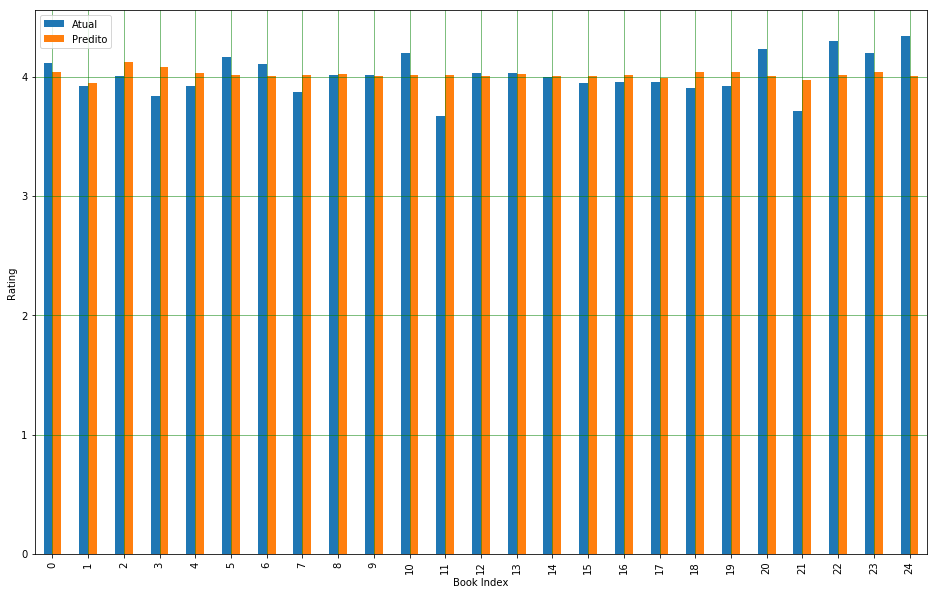

In [33]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.xlabel('Book Index')
plt.ylabel('Rating')
plt.show()

A partir do gráfico acima é possível entender que as previsões estão bem próximas das que são de verdade. Vamos então usar a métrica do R² para avaliar nossa regressão.

In [34]:
print("O R² é " + str(metrics.r2_score(df['Atual'],df['Predito'])))

O R² é -1.0669881042672031


Portanto, nosso modelo tem um R² de -1.0669881042672031 que significa que nosso modelo tem uma avaliação de que a nota atribuída pelo computador é normalmente menor que a que de fato é, em cerca de 1 ponto na classificação segundo o ranking do Goodreads.

## Como poderíamos iterar nosso modelo?


In [22]:
#Usando outro DataFrame (de 2018) para fazer a predição:
teste_X2 = pd.read_csv('book_data_2018.csv')

In [23]:
teste_X2.drop(['book_desc', 'book_edition', 'book_isbn', 'book_rating_count', 'book_review_count', 'image_url'], axis=1, inplace=True)
teste_X2=teste_X2.dropna()
teste_X2.head()

,book_authors,book_format,book_pages,book_rating,book_title,genres
0,Kristin Hannah,Kindle Edition,435 pages,4.33,The Great Alone,Fiction|Historical|Historical Fiction|Audioboo...
1,Madeline Miller,Hardcover,393 pages,4.34,Circe,Fantasy|Fiction|Fantasy|Mythology|Historical|H...
2,Holly Black,Hardcover,370 pages,4.18,The Cruel Prince,Fantasy|Young Adult|Fairies|Fae
3,A.J. Finn,Kindle Edition,449 pages,3.97,The Woman in the Window,Mystery|Thriller|Fiction|Suspense|Thriller|Mys...
4,Tara Westover,Hardcover,334 pages,4.47,Educated,Nonfiction|Autobiography|Memoir|Biography


In [24]:
ar_2018 = teste_X2['genres'].value_counts()
ar1_2018 = []
iniciais_2018 = []
paginas_2018 = []

# Escolhendo como gênero literário apenas o primeiro listado.
for i in ar_2018.index:
    if i == "":
        ar1_2018.append("")
    else:
        a = i.split('|')
        ar1_2018.append(a[0])
        
# Selecionando apenas a inicial dos nomes dos autores
for i in teste_X2['book_authors']:
    iniciais_2018.append(i[0])

# Apenas o número de páginas aparecerá, sem a palavra "pages"
for i in teste_X2['book_pages']:
    numero_2018 = i.split(' ')
    paginas_2018.append(int(numero_2018[0]))
print(paginas_2018[0:10])
print(iniciais_2018[0:10])
print(ar1_2018[0:10])

[435, 393, 370, 449, 334, 525, 308, 352, 346, 504]
['K', 'M', 'H', 'A', 'T', 'T', 'T', 'M', 'G', 'N']
['Romance', 'Romance', 'Fantasy', 'Fiction', 'Romance', 'Historical', 'Romance', 'Mystery', 'Romance', 'Fiction']


In [25]:
# Criando colunas no DataFrame para as iniciais dos autores, os números de páginas e o principal gênero do livro
ar1_2018=pd.DataFrame({'genero':ar1_2018})
iniciais_2018_ = pd.DataFrame({'iniciais':iniciais_2018})
paginas_2018_ = pd.DataFrame({'paginas':paginas_2018})

In [26]:
teste_X2 = teste_X2.join(ar1_2018,how='inner')
teste_X2 = teste_X2.join(iniciais_2018_,how='inner')
teste_X2 = teste_X2.join(paginas_2018_,how='inner')
teste_X2.head()

,book_authors,book_format,book_pages,book_rating,book_title,genres,genero,iniciais,paginas
0,Kristin Hannah,Kindle Edition,435 pages,4.33,The Great Alone,Fiction|Historical|Historical Fiction|Audioboo...,Romance,K,435
1,Madeline Miller,Hardcover,393 pages,4.34,Circe,Fantasy|Fiction|Fantasy|Mythology|Historical|H...,Romance,M,393
2,Holly Black,Hardcover,370 pages,4.18,The Cruel Prince,Fantasy|Young Adult|Fairies|Fae,Fantasy,H,370
3,A.J. Finn,Kindle Edition,449 pages,3.97,The Woman in the Window,Mystery|Thriller|Fiction|Suspense|Thriller|Mys...,Fiction,A,449
4,Tara Westover,Hardcover,334 pages,4.47,Educated,Nonfiction|Autobiography|Memoir|Biography,Romance,T,334


In [27]:
teste_X2.drop(['book_authors', 'book_pages', 'genres'], axis=1, inplace=True)
teste_X2.head()

,book_format,book_rating,book_title,genero,iniciais,paginas
0,Kindle Edition,4.33,The Great Alone,Romance,K,435
1,Hardcover,4.34,Circe,Romance,M,393
2,Hardcover,4.18,The Cruel Prince,Fantasy,H,370
3,Kindle Edition,3.97,The Woman in the Window,Fiction,A,449
4,Hardcover,4.47,Educated,Romance,T,334


In [28]:
y_pred2 = regressor.predict(teste_X2)

for i in range(len(y_pred2)):
    if y_pred2[i]>5:
        y_pred2[i]=5
    elif y_pred2[i]<0:
        y_pred2[i]=0
        
df2 = pd.DataFrame({'Atual': y_test2.flatten(), 'Predito': y_pred2.flatten()})
df2.head()

ValueError: could not convert string to float: 'Kindle Edition'

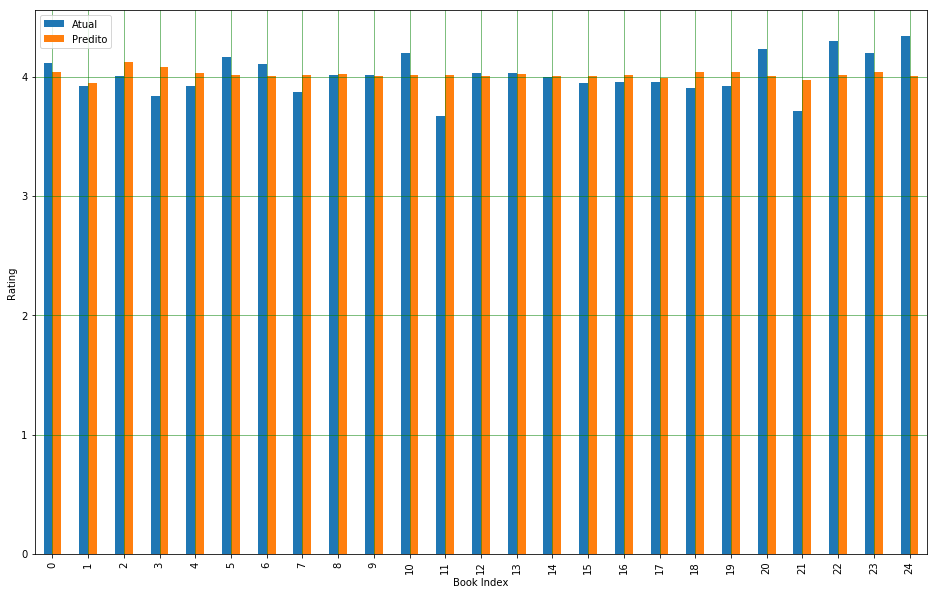

O R² é -1.0669881042672031
